In [1]:
import sys,os,gzip
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
%load_ext sql


/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
sys.path.append(os.path.sep.join(os.path.split(os.getcwd())[:-1]))

In [3]:
import splitter

Our test set here includes the 16 million molecules from the old ZINC clean set that could be successfully processed by the RDKit.

We use the Standard InChI that comes with ChEMBL and a non-standard InChI (options "/FixedH /SUU") that allows tautomers to be distinguished. Here's the sequence of psql commands used to generate that set:




In [4]:
%sql postgresql://localhost/inchi_split \
    select count(*) from zinc_clean_nonstandard;

1 rows affected.


count
16390000


*Big caveat here*: I forgot the last commit in my loading script, so the last block of structures is missing.

## Formula level grouping

In [5]:
d = %sql \
    select formula,count(zinc_id) freq from zinc_clean_nonstandard group by formula \
    order by freq desc limit 10;
d

10 rows affected.


formula,freq
/C17H26N2O2,13585
/C21H27N3O3,12718
/C16H24N2O2,12549
/C19H29N3O3,12371
/C19H26N4O2,12248
/C21H26N2O3,12228
/C19H27N3O3,11905
/C19H29N3O2,11891
/C20H24N2O3,11831
/C19H25N3O3,11609


## grouping on the main layer

In [6]:
d = %sql \
    select formula,skeleton,hydrogens,count(zinc_id) freq from zinc_clean_nonstandard group by \
    (formula,skeleton,hydrogens) \
    order by freq desc limit 10;

10 rows affected.


Look at a few of the common main layer groups

In [7]:
d[:5]

[('/C20H34O5', '/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(17)23)10-7-4-5-8-11-20(24)25', '/h4,7,12-13,15-19,21-23H,2-3,5-6,8-11,14H2,1H3,(H,24,25)', 36),
 ('/C28H44O', '/c1-19(2)20(3)9-10-22(5)26-15-16-27-23(8-7-17-28(26,27)6)12-13-24-18-25(29)14-11-21(24)4', '/h9-10,12-13,19-20,22,25-27,29H,4,7-8,11,14-18H2,1-3,5-6H3', 32),
 ('/C15H19NO6', '/c1-8(17)16-11-12(18)13-10(21-14(11)19)7-20-15(22-13)9-5-3-2-4-6-9', '/h2-6,10-15,18-19H,7H2,1H3,(H,16,17)', 31),
 ('/C12H20O6', '/c1-11(2)14-5-6(16-11)8-7(13)9-10(15-8)18-12(3,4)17-9', '/h6-10,13H,5H2,1-4H3', 30),
 ('/C8H15NO6', '/c1-3(11)9-5-7(13)6(12)4(2-10)15-8(5)14', '/h4-8,10,12-14H,2H2,1H3,(H,9,11)', 29)]

('/C20H34O5', '/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(17)23)10-7-4-5-8-11-20(24)25', '/h4,7,12-13,15-19,21-23H,2-3,5-6,8-11,14H2,1H3,(H,24,25)')
36 rows affected.


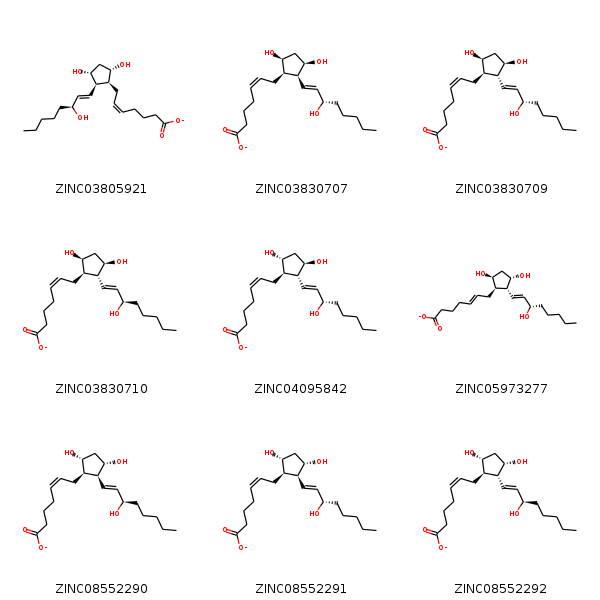

In [13]:
tpl=d[0][:-1]
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens) = :tpl 
cids = [x for x,y in rows][:9]
ms = [Chem.MolFromSmiles(y) for x,y in rows][:9]
Draw.MolsToGridImage(ms,legends=cids)

('/C28H44O', '/c1-19(2)20(3)9-10-22(5)26-15-16-27-23(8-7-17-28(26,27)6)12-13-24-18-25(29)14-11-21(24)4', '/h9-10,12-13,19-20,22,25-27,29H,4,7-8,11,14-18H2,1-3,5-6H3')
32 rows affected.


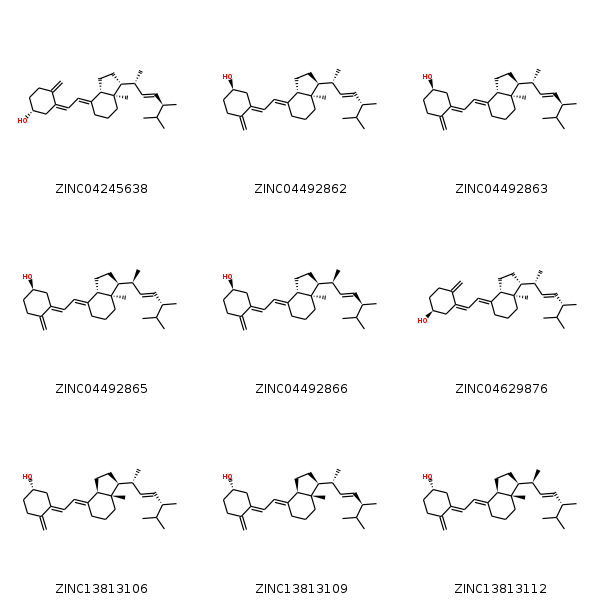

In [14]:
tpl=d[1][:-1]
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens) = :tpl
cids = [x for x,y in rows][:9]
ms = [Chem.MolFromSmiles(y) for x,y in rows][:9]
Draw.MolsToGridImage(ms,legends=cids)

('/C8H15NO6', '/c1-3(11)9-5-7(13)6(12)4(2-10)15-8(5)14', '/h4-8,10,12-14H,2H2,1H3,(H,9,11)')
29 rows affected.


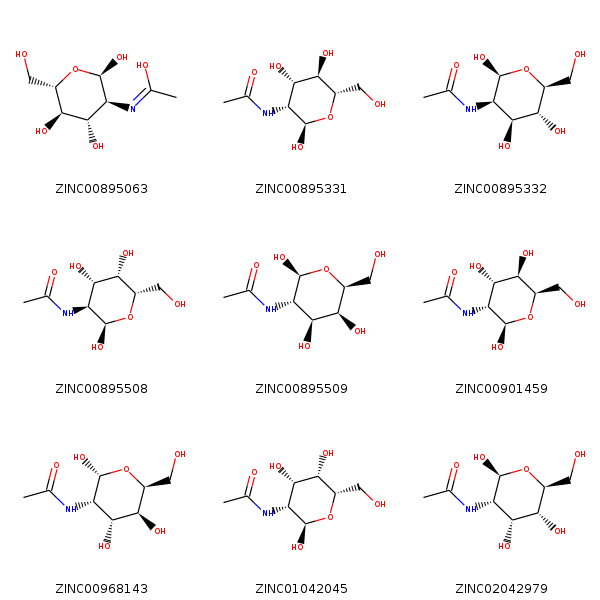

In [15]:
tpl=d[4][:-1]
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens) = :tpl
cids = [x for x,y in rows][:9]
ms = [Chem.MolFromSmiles(y) for x,y in rows][:9]
Draw.MolsToGridImage(ms,legends=cids)

## Charges

In [16]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,count(zinc_id) freq from zinc_clean_nonstandard group by \
    (formula,skeleton,hydrogens,charge,protonation) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C20H34O5', '/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(17)23)10-7-4-5-8-11-20(24)25', '/h4,7,12-13,15-19,21-23H,2-3,5-6,8-11,14H2,1H3,(H,24,25)', None, '/p-1', 36),
 ('/C28H44O', '/c1-19(2)20(3)9-10-22(5)26-15-16-27-23(8-7-17-28(26,27)6)12-13-24-18-25(29)14-11-21(24)4', '/h9-10,12-13,19-20,22,25-27,29H,4,7-8,11,14-18H2,1-3,5-6H3', None, None, 32),
 ('/C15H19NO6', '/c1-8(17)16-11-12(18)13-10(21-14(11)19)7-20-15(22-13)9-5-3-2-4-6-9', '/h2-6,10-15,18-19H,7H2,1H3,(H,16,17)', None, None, 31),
 ('/C12H20O6', '/c1-11(2)14-5-6(16-11)8-7(13)9-10(15-8)18-12(3,4)17-9', '/h6-10,13H,5H2,1-4H3', None, None, 30),
 ('/C8H15NO6', '/c1-3(11)9-5-7(13)6(12)4(2-10)15-8(5)14', '/h4-8,10,12-14H,2H2,1H3,(H,9,11)', None, None, 29)]

('/C20H34O5', '/c1-2-3-6-9-15(21)12-13-17-16(18(22)14-19(17)23)10-7-4-5-8-11-20(24)25', '/h4,7,12-13,15-19,21-23H,2-3,5-6,8-11,14H2,1H3,(H,24,25)', '', '/p-1')
36 rows affected.


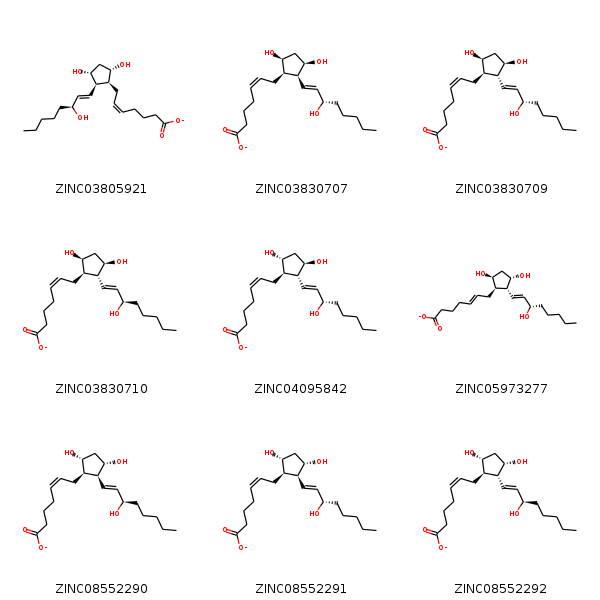

In [21]:
tpl=d[0][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens,coalesce(charge,''),coalesce(protonation,'')) = :tpl
cids = [x for x,y in rows][:9]
ms = [Chem.MolFromSmiles(y) for x,y in rows][:9]
Draw.MolsToGridImage(ms,legends=cids)

## Stereo grouping

In [26]:
d = %sql \
    select formula,skeleton,hydrogens,charge,protonation,stereo_bond,stereo_tet,stereo_m,stereo_s,count(zinc_id) freq \
    from zinc_clean_nonstandard where stereo_bond is not null or stereo_tet is not null \
    group by \
    (formula,skeleton,hydrogens,charge,protonation,stereo_bond,stereo_tet,stereo_m,stereo_s) \
    order by freq desc limit 10;
d[:5]

10 rows affected.


[('/C18H18Cl2N2O2S2', '/c1-18(2)8-12-14(13(23)9-18)16(25-15(12)20)26(3)22-17(24)21-11-6-4-10(19)5-7-11', '/h4-7H,8-9H2,1-3H3,(H,21,24)', None, None, None, '/t26?', None, None, 4),
 ('/C28H32N2O4', '/c1-17(18-9-7-6-8-10-18)30-23-14-12-20-21(16-24(23)31)22(29-2)13-11-19-15-25(32-3)27(33-4)28(34-5)26(19)20', '/h6-10,12,14-17,22,29H,11,13H2,1-5H3,(H,30,31)', None, '/p+1', None, '/t17-,22+', '/m1', '/s1', 3),
 ('/C12H16Br2O2', '/c13-11-2-8-1-10(5-11,4-9(15)16)6-12(14,3-8)7-11', '/h8H,1-7H2,(H,15,16)', None, '/p-1', None, '/t8?,10?,11-,12+', None, None, 3),
 ('/C21H16Cl2N2O3S', '/c1-29(25-21(27)24-17-8-6-16(23)7-9-17)19-12-10-18(11-13-19)28-20(26)14-2-4-15(22)5-3-14', '/h2-13H,1H3,(H,24,27)', None, None, None, '/t29?', None, None, 3),
 ('/C26H30N4O6', '/c1-15(2)13-20(25(34)35)28-22(31)16(3)27-23(32)21(14-17-9-5-4-6-10-17)30-24(33)18-11-7-8-12-19(18)29-26(30)36', '/h4-12,15-16,20-21H,13-14H2,1-3H3,(H,27,32)(H,28,31)(H,29,36)(H,34,35)', None, '/p-1', None, '/t16-,20-,21-', '/m0', '/s1', 3)]

('/C18H18Cl2N2O2S2', '/c1-18(2)8-12-14(13(23)9-18)16(25-15(12)20)26(3)22-17(24)21-11-6-4-10(19)5-7-11', '/h4-7H,8-9H2,1-3H3,(H,21,24)', '', '', '', '/t26?', '', '')
4 rows affected.


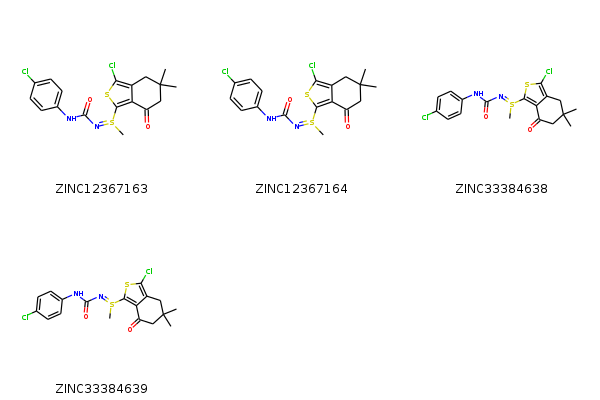

In [27]:
tpl=d[0][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,''),coalesce(stereo_bond,''),\
     coalesce(stereo_tet,''),coalesce(stereo_m,''),coalesce(stereo_s,'')) = :tpl   
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

('/C28H32N2O4', '/c1-17(18-9-7-6-8-10-18)30-23-14-12-20-21(16-24(23)31)22(29-2)13-11-19-15-25(32-3)27(33-4)28(34-5)26(19)20', '/h6-10,12,14-17,22,29H,11,13H2,1-5H3,(H,30,31)', '', '/p+1', '', '/t17-,22+', '/m1', '/s1')
3 rows affected.


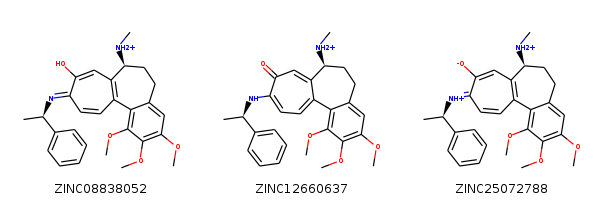

In [28]:
tpl=d[1][:-1]
tpl = tuple(x if x is not None else '' for x in tpl)
print(tpl)
rows = %sql \
  select zinc_id,smiles from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
    (formula,skeleton,hydrogens,\
     coalesce(charge,''),coalesce(protonation,''),coalesce(stereo_bond,''),\
     coalesce(stereo_tet,''),coalesce(stereo_m,''),coalesce(stereo_s,'')) = :tpl   
cids = [x for x,y in rows]
ms = [Chem.MolFromSmiles(y) for x,y in rows]
Draw.MolsToGridImage(ms,legends=cids)

### an aside

I discovered this little InChI pathology while doing this work. I spent a good half hour trying to track down the RDKit bug that made it happen before realizing that it's *by design*. Note that this is with FixedH InChIs.

6 rows affected.
+--------------+------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------+
|   zinc_id    |                                                         nonstandard_inchi                                                          |                             smiles                             |
+--------------+------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------+
| ZINC04701292 | InChI=1/C29H33N2/c1-28(2)22-16-12-14-18-24(22)30(5)26(28)20-10-8-7-9-11-21-27-29(3,4)23-17-13-15-19-25(23)31(27)6/h7-21H,1-6H3/q+1 | CN1/C(=C\C=C/C=C\C=C/C2=[N+](C)c3ccccc3C2(C)C)C(C)(C)c2ccccc21 |
| ZINC12405219 | InChI=1/C29H33N2/c1-28(2)22-16-12-14-18-24(22)30(5)26(28)20-10-8-7-9-11-21-27-29(3,4)23-17-13-15-19-25(23)

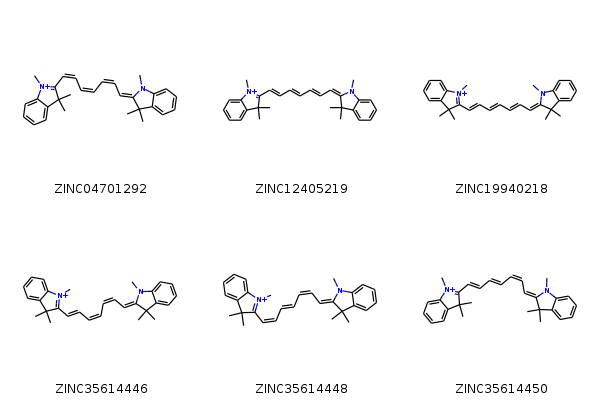

In [30]:
td = %sql \
select t2.zinc_id,t2.nonstandard_inchi,t2.smiles from zinc_clean_nonstandard t1 join zinc_clean t2 using (zinc_id) \
where (formula,skeleton,hydrogens,charge)=\
('/C29H33N2','/c1-28(2)22-16-12-14-18-24(22)30(5)26(28)20-10-8-7-9-11-21-27-29(3,4)23-17-13-15-19-25(23)31(27)6',\
 '/h7-21H,1-6H3','/q+1')
print(td)
cids = [x for x,y,z in td]
ms = [Chem.MolFromSmiles(z) for x,y,z in td]
Draw.MolsToGridImage(ms,legends=cids)

Sucks to be you if it's important to you that those molecules be different and you're using InChI.
Note that at least ZINC12405219 and ZINC19940218 are, according to ZINC, separately available from vendors

## Isotopes

In [42]:
%sql \
select count(*) \
    from zinc_clean_nonstandard where isotope is not null

1 rows affected.


count
0


No need here, this set has no labelled compounds. That's likely a property of how the ZINC clean set was constructed.

## examples where the tautomerism leads to new tetrahedral symmetry

In [57]:
rows = %sql \
  select zinc_id,smiles,nonstandard_inchi from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
     fixedh_stereo_tet is not null and position('?' in fixedh_stereo_tet)<=0 and stereo_tet!=fixedh_stereo_tet 
len(rows)

161 rows affected.


161

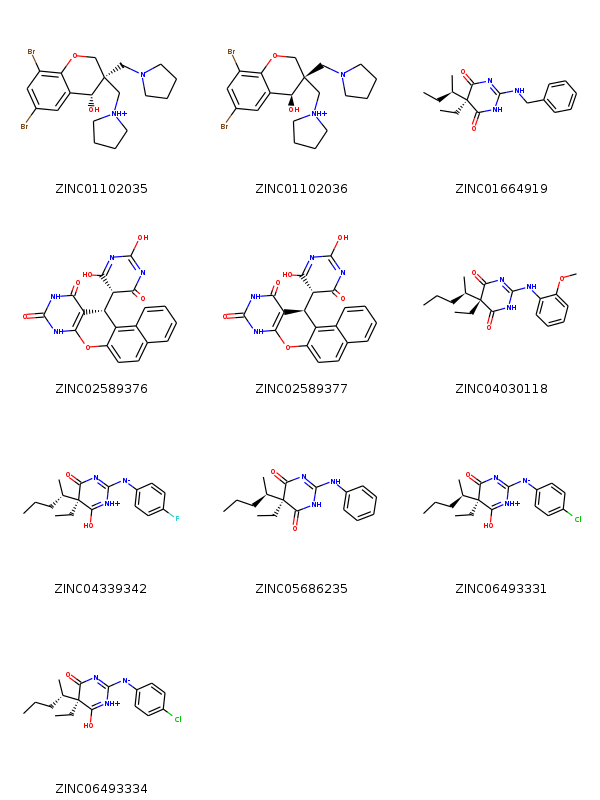

In [58]:
cids = [x for x,y,z in rows][:10]
ms = [Chem.MolFromSmiles(y) for x,y,z in rows][:10]
Draw.MolsToGridImage(ms,legends=cids)

Not much interesting there. There's no simple query to find questionable tautomer motion. :-)

## Examples where tautomerism leads to new bond stereochemistry

In [68]:
rows = %sql \
  select zinc_id,smiles,nonstandard_inchi from zinc_clean join zinc_clean_nonstandard using (zinc_id) where \
     fixedh_stereo_bond is not null and fixedh_stereo_bond!='/b' and position('?' in fixedh_stereo_bond)<=0 and stereo_bond!=fixedh_stereo_bond 
len(rows)

167 rows affected.


167

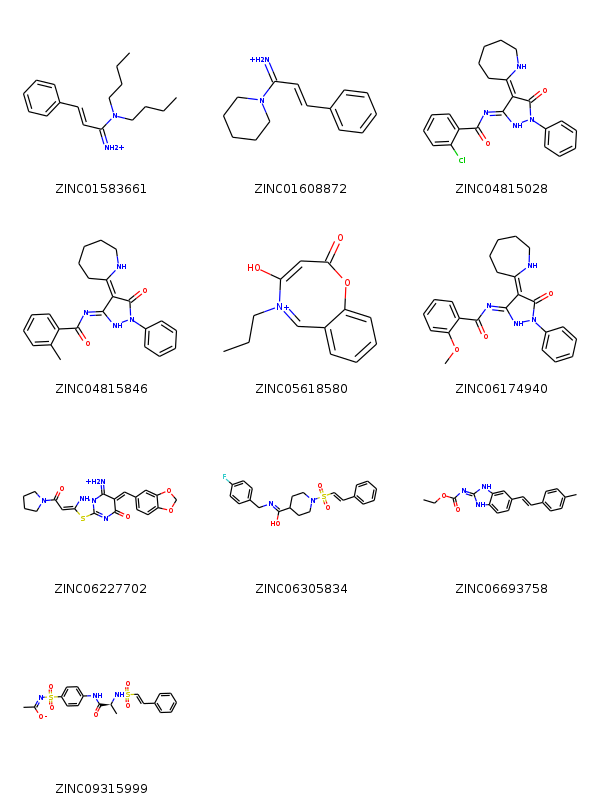

In [69]:
cids = [x for x,y,z in rows][:10]
ms = [Chem.MolFromSmiles(y) for x,y,z in rows][:10]
Draw.MolsToGridImage(ms,legends=cids)

Not much interesting in those first results